In [1]:
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from collections import Counter
from IPython.display import display_html
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
sns.set(style="whitegrid")

# supervised learning models
from sklearn import ensemble
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# deep neutral network
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# text manipulation tools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF
import spacy
from wordcloud import WordCloud

In [ ]:
# Load and Clean Dataset

In [ ]:
path = "C:\\Users\\James\\Desktop\\Data_Folder\\yelp\\"

biz=pd.read_csv(path + "yelp_business.csv")
reviews=pd.read_csv(path + "yelp_review.csv")

In [ ]:
#biz_attributes=pd.read_csv(path + "yelp_biz_attributes.csv")
#biz_hours=pd.read_csv(path + "yelp_biz_hours.csv")
#check_in=pd.read_csv(path + "yelp_checkin.csv")
#tip=pd.read_csv(path + "yelp_tip.csv")
#user=pd.read_csv(path + "yelp_user.csv")

In [ ]:
reviews.info()

In [ ]:
biz.info()

In [ ]:
# load dataset
biz=pd.read_csv(path + "yelp_business.csv")

# remove unnecessary columns; note that stars is total stars for biz
col = ['neighborhood', 'address', 'latitude', 'longitude', 'stars']
biz.drop(columns=col, inplace=True)       

# update categories so that it's a list and not a string
biz.categories = biz.categories.apply(lambda x: x.split(";"))

# we will filter open restaurants in Phoenix, AZ only
biz = biz[
    (biz.city == 'Cleveland') & 
    (biz.state == 'OH') & 
    (biz.is_open == 1) & 
    (biz.categories.apply(
        lambda x: True if 'Restaurants' in x else False
    ))]

In [ ]:
df = pd.merge(reviews, biz, how='inner', on='business_id')
df.head()

In [ ]:
# still have a lot of rows and no null values
df.info()

# Exploratory Data Analysis

## Text Preprocessing

In [ ]:
# removes punctation, stops words, and lemmatizes
def lemma(text):
    lem_text = []
    
    for token in text:
        if (not token.is_punct and 
            not token.is_stop and 
            not token.like_email and
            not token.like_url and
            token.lemma not in nlp.Defaults.stop_words): 
            lem_text.append(token.lemma_.lower())
    
    return " ".join(lem_text)

In [ ]:
# let's create lemmatized sentences
nlp = spacy.load("en_core_web_sm")
df['lem_join'] = df.text.apply(lambda x: lemma(nlp(x)))

df.head()

In [ ]:
# we can't have lists in feather format
df.drop(columns='categories', inplace=True)  

# create feather backup
df.reset_index(drop=True).to_feather('yelp_reviews.feather')

# +++++++ Start Here +++++++++

In [2]:
df = pd.read_feather('yelp_reviews.feather')

## Explore the Data

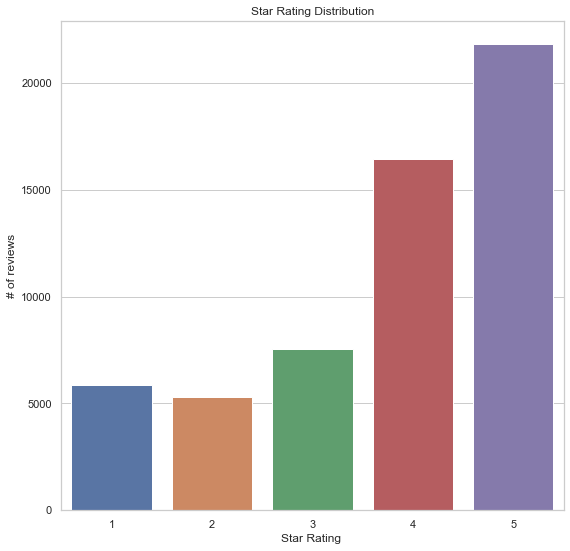

In [3]:
plt.figure(figsize=(9,9))
sns.countplot(x='stars', data=df)
plt.ylabel('# of reviews')
plt.xlabel('Star Rating ')
plt.title("Star Rating Distribution");

In [4]:
df['target'] = df['stars'].apply(lambda x: 0 if x >= 4 else 1)

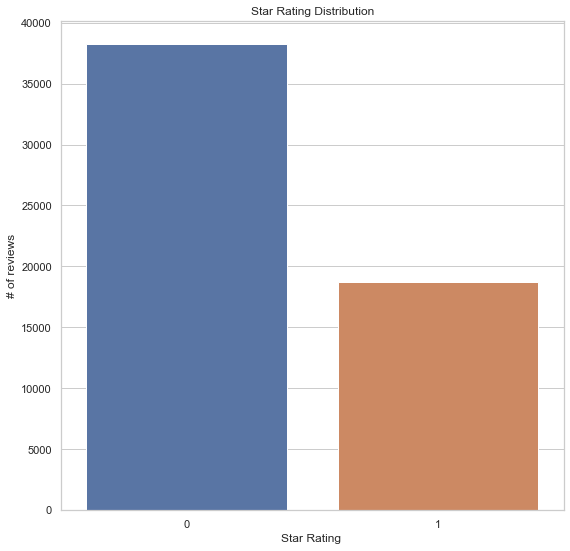

In [5]:
plt.figure(figsize=(9,9))
sns.countplot(x='target', data=df)
plt.ylabel('# of reviews')
plt.xlabel('Star Rating ')
plt.title("Star Rating Distribution");

In [6]:
'''
combined_words = ''

for review in df.lem_join:
    combined_words += review + " "
    
wordcloud = WordCloud(width = 800, 
                      height = 800, 
                      background_color ='white', 
                      min_font_size = 10).generate(combined_words)    
'''

'\ncombined_words = \'\'\n\nfor review in df.lem_join:\n    combined_words += review + " "\n    \nwordcloud = WordCloud(width = 800, \n                      height = 800, \n                      background_color =\'white\', \n                      min_font_size = 10).generate(combined_words)    \n'

In [7]:
'''
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
'''

'\n# plot the WordCloud image                        \nplt.figure(figsize = (8, 8), facecolor = None) \nplt.imshow(wordcloud) \nplt.axis("off") \nplt.tight_layout(pad = 0) \n'

## Train-test split the data

In [8]:
# declare X & Y
Y = df['target']
X = df['lem_join']

# let's stratify the data so we get a fair balance
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=42, stratify=Y
)

## Prep BoW

In [9]:
def BoW_generator(text):
    
    # get the top 2000 words
    n_top_words = 2000
    count_vec = CountVectorizer(max_features=n_top_words)
    mask = count_vec.fit_transform(text)
    
    # create a dataframe
    word_counts = pd.DataFrame(
        mask.toarray().reshape(-1, n_top_words), 
        columns=count_vec.get_feature_names()
    )  
    
    return word_counts

In [10]:
# get the top 2000 words
n_top_words = 2000
count_vec = CountVectorizer(max_features=n_top_words)

# apply to X values
X_train_bow = count_vec.fit_transform(X_train)
X_test_bow = count_vec.transform(X_test)

## Prep Tf-Idf

In [11]:
tfidf_vec = TfidfVectorizer(
    max_df=0.5, 
    min_df=2,
    stop_words='english', 
    lowercase=True,
    use_idf=True,
    norm=u'l2',
    smooth_idf=True
)

In [12]:
# applying to X values
X_train_tfidf=tfidf_vec.fit_transform(X_train)
X_test_tfidf=tfidf_vec.transform(X_test)

# Phase 1: Sentiment Analysis of Yelp Reviews

In [13]:
def model_metrics(model, X, y):
    model_sum = {}
    
    # get cross validation score & mean of CV score
    cv_score = cross_val_score(model, X, y, cv=10, n_jobs=-1)
    
    model_sum['cv_scores'] = list(cv_score)
    model_sum['cv_mean'] = np.mean(cv_score)
    
    # get confusion matrix metrics
    y_pred = model.predict(X)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    
    model_sum['true negatives'] = tn
    model_sum['false positives'] = fp
    model_sum['false negatives'] = fn
    model_sum['true positives'] = tp
    model_sum['accuracy'] = (tp+tn)/len(y_pred)
    model_sum['f1 score'] = 2*tp/(2*tp+fp+fn)
    model_sum['class_report'] = classification_report(y, y_pred)
    
    return model_sum

In [14]:
def format_metrics(model_sum):
    # print cross-validation scores
    print("Cross Validation Scores\n" + 23*"=" + "\n{}\n".format(model_sum['cv_scores']))
    print("Average CV = {}\n".format(model_sum['cv_mean']))
    
    # print classification report
    print("Classification Report\n" + 21*"=" + "\n" + model_sum['class_report'])
    
    # print confusion matrix results
    print("Confusion Matrix\n" + 16*"=" + '\nTrue Positives = {}\nTrue Negatives'\
          '= {}\nFalse Positives = {}\nFalse Negatives = {}'\
          .format(model_sum['true positives'], 
                  model_sum['true negatives'], 
                  model_sum['false positives'], 
                  model_sum['false negatives']))

## Logistic Regression

In [15]:
# set parameters
params = {
    'penalty': 'l2',
    'fit_intercept': True, 
    'max_iter': 50, 
    'n_jobs':-1, 
    'dual': False
}

In [16]:
lrm_model1 = LogisticRegression(**params)
lrm_model2 = LogisticRegression(**params)

# fit both models
lrm_model1.fit(X_train_bow, y_train)
lrm_model2.fit(X_train_tfidf, y_train)

# prep and display metrics
lrm_results_bow = model_metrics(lrm_model1, X_train_bow, y_train)
lrm_results_tfidf = model_metrics(lrm_model2, X_train_tfidf, y_train)

print('Logistic Regression Model (BoW)')
format_metrics(lrm_results_bow)

print('\n\nLogistic Regression Model (Tf-Idf)')
format_metrics(lrm_results_tfidf)

Logistic Regression Model (BoW)
Cross Validation Scores
[0.8683532443195128, 0.8793628484422581, 0.8798031865042174, 0.8690253045923149, 0.877460168697282, 0.8734770384254921, 0.880037488284911, 0.8697282099343955, 0.8762886597938144, 0.876991565135895]

Average CV = 0.8750527714130094

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.95      0.93     28665
           1       0.88      0.79      0.84     14017

    accuracy                           0.90     42682
   macro avg       0.89      0.87      0.88     42682
weighted avg       0.90      0.90      0.90     42682

Confusion Matrix
True Positives = 11142
True Negatives= 27158
False Positives = 1507
False Negatives = 2875


Logistic Regression Model (Tf-Idf)
Cross Validation Scores
[0.8746779105176856, 0.8831107987819161, 0.8863636363636364, 0.8821462043111528, 0.8802717900656045, 0.8823805060918463, 0.8851921274601687, 0.877460168697282, 0.8882380506091846, 0.881208997188

## Naive Bayes Classification

In [17]:
# set parameters
params = {
}

In [18]:
clf_model1 = MultinomialNB(**params)
clf_model2 = MultinomialNB(**params)

# fit both models
clf_model1.fit(X_train_bow, y_train)
clf_model2.fit(X_train_tfidf, y_train)

# prep and display metrics
clf_results_bow = model_metrics(clf_model1, X_train_bow, y_train)
clf_results_tfidf = model_metrics(clf_model2, X_train_tfidf, y_train)

print('Naive Bayes Model (BoW)')
format_metrics(clf_results_bow)

print('\n\nNaive Bayes Model (Tf-Idf)')
format_metrics(clf_results_tfidf)

Naive Bayes Model (BoW)
Cross Validation Scores
[0.8535956898571094, 0.8571093933005388, 0.8596532333645736, 0.862933458294283, 0.8645735707591378, 0.8591846298031866, 0.8535613870665417, 0.8530927835051546, 0.8608247422680413, 0.852389878163074]

Average CV = 0.857691876638164

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     28665
           1       0.81      0.75      0.78     14017

    accuracy                           0.86     42682
   macro avg       0.85      0.83      0.84     42682
weighted avg       0.86      0.86      0.86     42682

Confusion Matrix
True Positives = 10495
True Negatives= 26264
False Positives = 2401
False Negatives = 3522


Naive Bayes Model (Tf-Idf)
Cross Validation Scores
[0.8280627781681893, 0.8327477160927618, 0.8329428303655108, 0.8315370196813496, 0.8329428303655108, 0.8324742268041238, 0.834817244611059, 0.8284910965323337, 0.8320056232427366, 0.8364573570759137]

Average C

## Linear Support Vector Classification

In [19]:
params = {
    'loss': 'log', 
    'penalty': 'l2', 
    'alpha': 1e-3, 
    'random_state': 42, 
    'max_iter': 5, 
    'tol': None
}

In [20]:
svc_model1 = SGDClassifier(**params)
svc_model2 = SGDClassifier(**params)

# fit both models
svc_model1.fit(X_train_bow, y_train)
svc_model2.fit(X_train_tfidf, y_train)

# prep and display metrics
svc_results_bow = model_metrics(svc_model1, X_train_bow, y_train)
svc_results_tfidf = model_metrics(svc_model2, X_train_tfidf, y_train)

print('Support Vector Classification Model (BoW)')
format_metrics(svc_results_bow)

print('\n\nSupport Vector Classification Model (Tf-Idf)')
format_metrics(svc_results_tfidf)

Support Vector Classification Model (BoW)
Cross Validation Scores
[0.8674162567345982, 0.880065589130944, 0.8793345829428304, 0.8727741330834115, 0.8767572633552015, 0.8786316776007498, 0.8760543580131209, 0.8666822867853796, 0.8791002811621368, 0.8701968134957826]

Average CV = 0.8747013242304155

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     28665
           1       0.87      0.77      0.82     14017

    accuracy                           0.89     42682
   macro avg       0.88      0.86      0.87     42682
weighted avg       0.89      0.89      0.89     42682

Confusion Matrix
True Positives = 10769
True Negatives= 27096
False Positives = 1569
False Negatives = 3248


Support Vector Classification Model (Tf-Idf)
Cross Validation Scores
[0.7819161396111501, 0.7887092996017803, 0.7933458294283037, 0.796157450796626, 0.7902999062792877, 0.7910028116213683, 0.7919400187441424, 0.7806935332708529, 0.7917057169

## LSTM in Keras

In [21]:
# this will create and set parameters of Keras model
def create_keras_model(X):
    input_dim = X.shape[1]
    model = Sequential()
    model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    return model 

# this will fit and evaluate keras model
def fit_eval_keras(X, y):
    
    # set up variables
    n_splits = 10
    kfold = StratifiedKFold(
        n_splits=n_splits, 
        shuffle=True, 
        random_state=42
    )
    
    y_predict = np.zeros((X.shape[0], 1))
    proba = np.zeros((X.shape[0], 1))
    models = []
    cv_score = []
    fold = 1
    for train, test in kfold.split(X, y):
        # set up Keras model
        model = create_keras_model(X[train])
        
        # fit each model
        model.fit(X[train], y[train], epochs=10, batch_size=200, verbose=0)
        
        # get prediction for each model
        predict = model.predict(X)
        y_predict += predict
        
        # get probablities for roc plot
        proba = model.predict_proba(X)
        
        # get cv scores
        scores = model.evaluate(X[test], y[test], verbose=0)
        cv_score.append(scores[1])
        
        print(f'Fold {fold} out of {n_splits} complete!')
        fold += 1
    
    # get average prediction of each model
    y_predict /= n_splits
    proba /= n_splits
    
    # create confusion matrix
    tn, fp, fn, tp = confusion_matrix(y, y_predict.round()).ravel()
    
    # save metrics in a dictionary
    model_sum = {}
    
    model_sum['cv_scores'] = cv_score
    model_sum['cv_mean'] = np.mean(cv_score)
    
    model_sum['true negatives'] = tn
    model_sum['false positives'] = fp
    model_sum['false negatives'] = fn
    model_sum['true positives'] = tp
    model_sum['accuracy'] = (tp+tn)/len(y_predict)
    model_sum['f1 score'] = 2*tp/(2*tp+fp+fn)
    model_sum['class_report'] = classification_report(y, y_predict.round())
    
    print('Evaluation Complete\n')
    # submit ensemble
    return [model_sum, proba]

In [23]:
keras_results_bow = fit_eval_keras(X_train_bow, y_train.factorize()[0])
keras_results_tfidf = fit_eval_keras(X_train_tfidf, y_train.factorize()[0])

print('Keras Classification Model (BoW)')
format_metrics(keras_results_bow[0])

print('\n\nKeras Classification Model (Tf-Idf)')
format_metrics(keras_results_tfidf[0])

Instructions for updating:
Use tf.cast instead.
Fold 1 out of 10 complete!
Fold 2 out of 10 complete!
Fold 3 out of 10 complete!
Fold 4 out of 10 complete!
Fold 5 out of 10 complete!
Fold 6 out of 10 complete!
Fold 7 out of 10 complete!
Fold 8 out of 10 complete!
Fold 9 out of 10 complete!
Fold 10 out of 10 complete!
Evaluation Complete

Fold 1 out of 10 complete!
Fold 2 out of 10 complete!
Fold 3 out of 10 complete!
Fold 4 out of 10 complete!
Fold 5 out of 10 complete!
Fold 6 out of 10 complete!
Fold 7 out of 10 complete!
Fold 8 out of 10 complete!
Fold 9 out of 10 complete!
Fold 10 out of 10 complete!
Evaluation Complete

Keras Classification Model (BoW)
Cross Validation Scores
[0.8760834, 0.86882174, 0.8781631, 0.8725398, 0.8685567, 0.8776945, 0.8779288, 0.8692596, 0.8723055, 0.87582004]

Average CV = 0.873717188835144

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     28665
           1       0.88      0.80 

# Summary of results

In [24]:
keys = ['cv_mean', 'accuracy', 'f1 score', 
        'true positives', 'true negatives', 
        'false positives', 'false negatives', ]

names = [
    'Logistic Regression Model (BoW)', 
    'Logistic Regression Model (Tf-Idf)', 
    'Naive Bayes Model (BoW)', 
    'Naive Bayes Model (Tf-Idf)', 
    'Support Vector Classification Model (BoW)', 
    'Support Vector Classification Model (Tf-Idf)', 
    'Keras Classification Model (BoW)',
    'Keras Classification Model (Tf-Idf)',
]

models = [
    lrm_results_bow, lrm_results_tfidf, 
    clf_results_bow, clf_results_tfidf, 
    svc_results_bow, svc_results_tfidf, 
    keras_results_bow[0], keras_results_tfidf[0], 
]
comb = {}

# combine them into one dictionary
for k in keys:
    comb[k] = tuple(comb[k] for comb in models)

# plot that dictionary into a dataframe
summary = pd.DataFrame.from_dict(comb)
summary.set_index(pd.Index(names))

,cv_mean,accuracy,f1 score,true positives,true negatives,false positives,false negatives
Logistic Regression Model (BoW),0.875053,0.897334,0.835671,11142,27158,1507,2875
Logistic Regression Model (Tf-Idf),0.882105,0.906049,0.848416,11222,27450,1215,2795
Naive Bayes Model (BoW),0.857692,0.861230,0.779920,10495,26264,2401,3522
Naive Bayes Model (Tf-Idf),0.832248,0.851506,0.720891,8185,28159,506,5832
Support Vector Classification Model (BoW),0.874701,0.887142,0.817226,10769,27096,1569,3248
Support Vector Classification Model (Tf-Idf),0.789466,0.792840,0.552440,5457,28383,282,8560
Keras Classification Model (BoW),0.873717,0.900286,0.840778,11237,27189,1476,2780
Keras Classification Model (Tf-Idf),0.878661,0.942903,0.911133,12493,27752,913,1524


In [25]:
# print ROC curve for LRM BoW
preds = lrm_model1.predict_proba(X_train_bow)[:,1]
fpr_lrm_bow, tpr_lrm_bow, threshold = roc_curve(y_train, preds)
lrm_auc_bow = auc(fpr_lrm_bow, tpr_lrm_bow)

# print ROC curve for LRM tf-idf
preds = lrm_model2.predict_proba(X_train_tfidf)[:,1]
fpr_lrm_tfidf, tpr_lrm_tfidf, threshold = roc_curve(y_train, preds)
lrm_auc_tfidf = auc(fpr_lrm_tfidf, tpr_lrm_tfidf)

In [26]:
# print ROC curve for CLF BoW
preds = clf_model1.predict_proba(X_train_bow)[:,1]
fpr_clf_bow, tpr_clf_bow, threshold = roc_curve(y_train, preds)
clf_auc_bow = auc(fpr_clf_bow, tpr_clf_bow)

# print ROC curve for CLF tf-idf
preds = clf_model2.predict_proba(X_train_tfidf)[:,1]
fpr_clf_tfidf, tpr_clf_tfidf, threshold = roc_curve(y_train, preds)
clf_auc_tfidf = auc(fpr_clf_tfidf, tpr_clf_tfidf)

In [27]:
# print ROC curve for SVC BoW
preds = svc_model1.predict_proba(X_train_bow)[:,1]
fpr_svc_bow, tpr_svc_bow, threshold = roc_curve(y_train, preds)
svc_auc_bow = auc(fpr_svc_bow, tpr_svc_bow)

# print ROC curve for SVC tf-idf
preds = svc_model2.predict_proba(X_train_tfidf)[:,1]
fpr_svc_tfidf, tpr_svc_tfidf, threshold = roc_curve(y_train, preds)
svc_auc_tfidf = auc(fpr_svc_tfidf, tpr_svc_tfidf)

In [28]:
y_train.factorize()

(array([0, 0, 0, ..., 1, 0, 0], dtype=int64),
 Int64Index([0, 1], dtype='int64'))

In [29]:
# print ROC curve for Keras BoW
preds = keras_results_bow[1]
fpr_keras_bow, tpr_keras_bow, threshold = roc_curve(y_train.factorize()[0], preds)
keras_auc_bow = auc(fpr_keras_bow, tpr_keras_bow)

# print ROC curve for Keras tf-idf
preds = keras_results_tfidf[1]
fpr_keras_tfidf, tpr_keras_tfidf, threshold = roc_curve(y_train.factorize()[0], preds)
keras_auc_tfidf = auc(fpr_keras_tfidf, tpr_keras_tfidf)

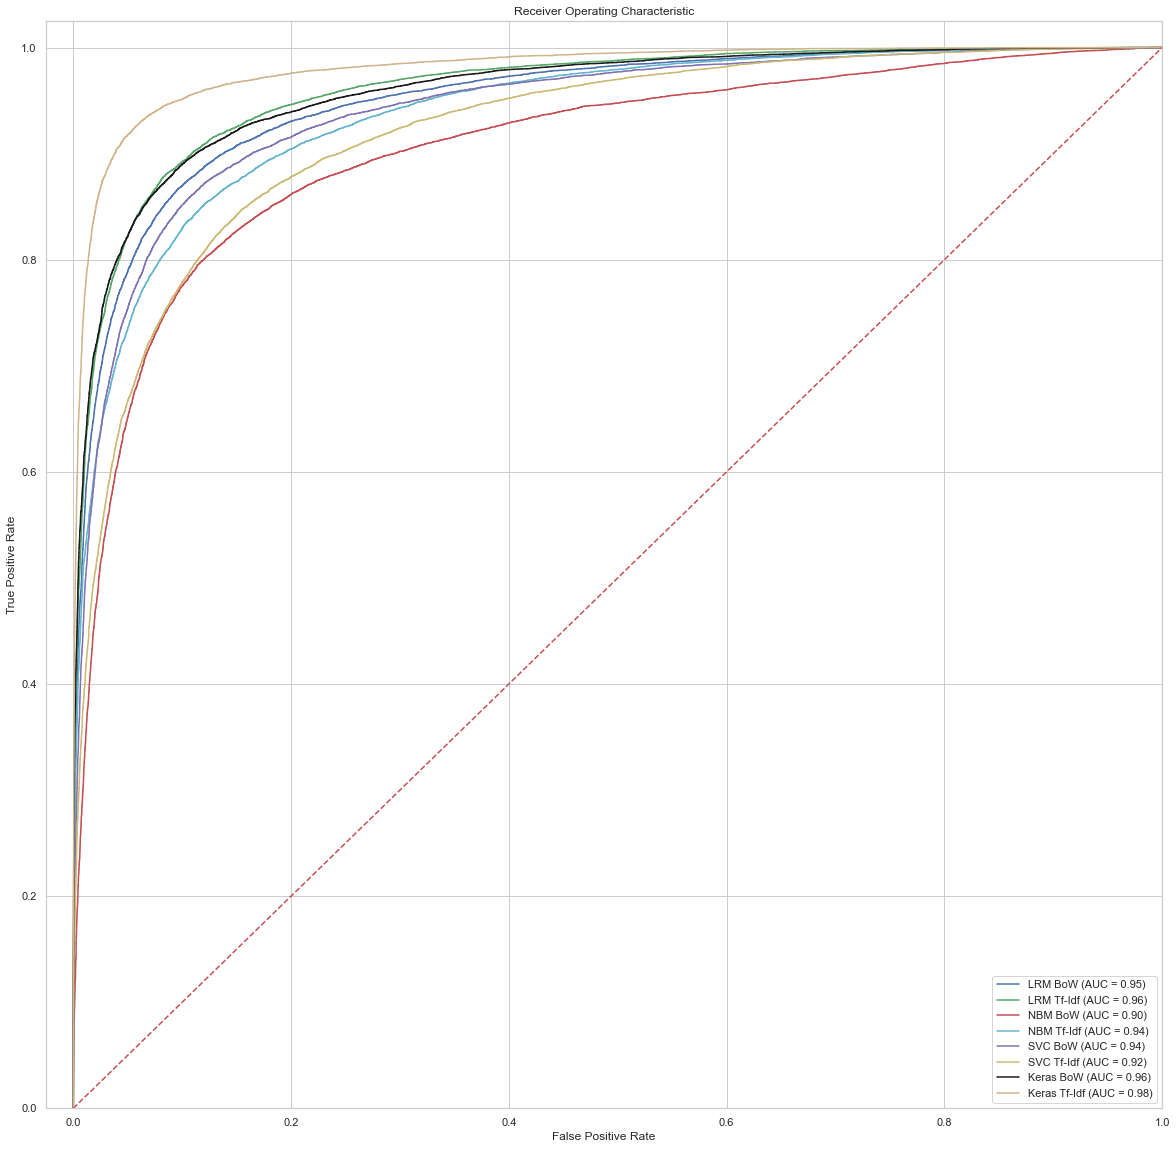

In [30]:
plt.figure(figsize=(20,20))
plt.title('Receiver Operating Characteristic')

# LRM Plots
plt.plot(fpr_lrm_bow, tpr_lrm_bow, 'b', 
         label = 'LRM BoW (AUC = %0.2f)' % lrm_auc_bow)
plt.plot(fpr_lrm_tfidf, tpr_lrm_tfidf, 'g', 
         label = 'LRM Tf-Idf (AUC = %0.2f)' % lrm_auc_tfidf)

# NBM Plots
plt.plot(fpr_clf_bow, tpr_clf_bow, 'r', 
         label = 'NBM BoW (AUC = %0.2f)' % clf_auc_bow)
plt.plot(fpr_clf_tfidf, tpr_clf_tfidf, 'c', 
         label = 'NBM Tf-Idf (AUC = %0.2f)' % clf_auc_tfidf)

# SVC Plots
plt.plot(fpr_svc_bow, tpr_svc_bow, 'm', 
         label = 'SVC BoW (AUC = %0.2f)' % svc_auc_bow)
plt.plot(fpr_svc_tfidf, tpr_svc_tfidf, 'y', 
         label = 'SVC Tf-Idf (AUC = %0.2f)' % svc_auc_tfidf)

# Keras Plots
plt.plot(fpr_keras_bow, tpr_keras_bow, 'k', 
         label = 'Keras BoW (AUC = %0.2f)' % keras_auc_bow)
plt.plot(fpr_keras_tfidf, tpr_keras_tfidf, 'tan', 
         label = 'Keras Tf-Idf (AUC = %0.2f)' % keras_auc_tfidf)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.025, 1])
plt.ylim([0, 1.025])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()